In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import spacy 
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim_models  
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!dir

 Volume in drive C is Windows 
 Volume Serial Number is 5275-53B3

 Directory of C:\Users\Devdatta Supnekar\Desktop\Imarticus\Trainings\NLP\Topic Modeling

11-12-2021  07:15    <DIR>          .
11-12-2021  07:15    <DIR>          ..
11-12-2021  07:14    <DIR>          .ipynb_checkpoints
11-02-2021  11:17            38,749 1. Topic_modeling_LDA.ipynb
11-02-2021  11:17            37,922 2. Topic_modeling_NMF.ipynb
11-02-2021  11:17            29,238 3. Topic_modeling_NMF_QUORA_DATA.ipynb
23-06-2021  18:08           150,044 4. Topic Modeling and Clustering.ipynb
04-06-2021  11:47         5,057,493 bbc-text.csv
11-12-2021  07:15         1,989,177 bigram and trigram analysis.ipynb
02-07-2021  13:04         2,311,037 Topic Modeling Visualisation.ipynb
               7 File(s)      9,613,660 bytes
               3 Dir(s)  145,005,760,512 bytes free


In [5]:
df = pd.read_csv("bbc-text.csv")
# df2 = pd.read_csv("1st_Input_df_for_tm.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.shape

(2225, 2)

In [7]:
# chekc duplicates 
df.duplicated().sum()

99

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.shape

(2126, 2)

In [11]:
stop_words = stopwords.words('english')
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'stopwords/extended_stopwords.txt'

In [12]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [13]:
# Convert to list
data = df.text.values.tolist()
print(len(data))

2126


In [14]:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[0])

('tv future in the hands of viewers with home theatre systems plasma '
 'high-definition tvs and digital video recorders moving into the living room '
 'the way people watch tv will be radically different in five years time. that '
 'is according to an expert panel which gathered at the annual consumer '
 'electronics show in las vegas to discuss how these new technologies will '
 'impact one of our favourite pastimes. with the us leading the trend '
 'programmes and other content will be delivered to viewers via home networks '
 'through cable satellite telecoms companies and broadband service providers '
 'to front rooms and portable devices. one of the most talked-about '
 'technologies of ces has been digital and personal video recorders (dvr and '
 'pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow '
 'people to record store play pause and forward wind tv programmes when they '
 'want. essentially the technology allows for much more personalised tv. they 

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[0])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [17]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# See bigram example
print(bigram_mod[data_words[0]])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition', 'tvs', 'and', 'digital', 'video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics', 'show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital',

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [21]:
print(len(data_lemmatized))

2126


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 7), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 5), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 3), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 4), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 2), (80, 1), (81, 1), (82, 1), (83, 4), (84, 2), (85, 3), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 3), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 2), (110, 1),

In [23]:
len(corpus)

2126

In [24]:
id2word[0]

'abide'

In [25]:
len(id2word)

17988

In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abide', 1),
  ('accord', 1),
  ('add', 1),
  ('advert', 1),
  ('advertising', 2),
  ('allow', 2),
  ('already', 1),
  ('also', 3),
  ('announce', 1),
  ('annual', 1),
  ('available', 1),
  ('big', 2),
  ('bill_gate', 1),
  ('book', 1),
  ('box', 1),
  ('brand', 7),
  ('broadband', 2),
  ('broadcaster', 1),
  ('build', 2),
  ('business', 1),
  ('button', 1),
  ('cable', 2),
  ('call', 1),
  ('capability', 2),
  ('carte', 1),
  ('ce', 2),
  ('challenge', 1),
  ('channel', 5),
  ('chief', 1),
  ('choice', 2),
  ('comfortable', 1),
  ('commercial', 1),
  ('communication', 1),
  ('company', 3),
  ('concern', 1),
  ('connection', 1),
  ('consumer', 1),
  ('consumer_electronic', 1),
  ('content', 4),
  ('control', 1),
  ('crystal', 1),
  ('deliver', 1),
  ('device', 1),
  ('diaper', 1),
  ('different', 1),
  ('digital', 2),
  ('directtv', 1),
  ('discuss', 1),
  ('display', 1),
  ('dvd', 1),
  ('dvr', 4),
  ('end', 1),
  ('enhance', 1),
  ('entertainment', 1),
  ('essentially', 1),
  ('ev

In [27]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [28]:
# Can take a long time to run
model_list, coherence_values = tune_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:59<00:00, 49.96s/it]


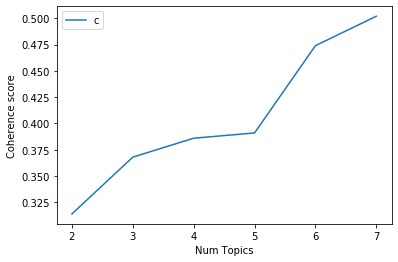

In [29]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.314
Num Topics = 3  has Coherence Value of 0.368
Num Topics = 4  has Coherence Value of 0.386
Num Topics = 5  has Coherence Value of 0.391
Num Topics = 6  has Coherence Value of 0.474
Num Topics = 7  has Coherence Value of 0.502


In [31]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"say" + 0.011*"people" + 0.009*"labour" + 0.008*"party" + '
  '0.008*"government" + 0.006*"election" + 0.006*"also" + 0.005*"make" + '
  '0.005*"tell" + 0.005*"plan"'),
 (1,
  '0.025*"film" + 0.024*"year" + 0.017*"rise" + 0.016*"sale" + 0.012*"award" + '
  '0.010*"say" + 0.010*"fall" + 0.009*"good" + 0.009*"figure" + '
  '0.009*"dollar"'),
 (2,
  '0.017*"say" + 0.014*"use" + 0.013*"people" + 0.008*"technology" + '
  '0.007*"game" + 0.006*"make" + 0.006*"network" + 0.006*"phone" + 0.006*"tv" '
  '+ 0.006*"music"'),
 (3,
  '0.031*"say" + 0.009*"year" + 0.008*"company" + 0.007*"firm" + '
  '0.006*"report" + 0.006*"also" + 0.005*"government" + 0.005*"share" + '
  '0.005*"country" + 0.005*"new"'),
 (4,
  '0.013*"say" + 0.010*"get" + 0.010*"play" + 0.009*"go" + 0.009*"year" + '
  '0.009*"game" + 0.008*"good" + 0.008*"time" + 0.008*"first" + 0.007*"win"')]


In [32]:
x = optimal_model.show_topics(num_topics=5, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
print()

print("---------------------")

0::['say', 'people', 'labour', 'party', 'government', 'election', 'also', 'make', 'tell', 'plan']
1::['film', 'year', 'rise', 'sale', 'award', 'say', 'fall', 'good', 'figure', 'dollar']
2::['say', 'use', 'people', 'technology', 'game', 'make', 'network', 'phone', 'tv', 'music']
3::['say', 'year', 'company', 'firm', 'report', 'also', 'government', 'share', 'country', 'new']
4::['say', 'get', 'play', 'go', 'year', 'game', 'good', 'time', 'first', 'win']

---------------------


In [33]:
len(optimal_model[corpus])

2126

In [34]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df["Text"] = contents 
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_topic_sents_keywords.head(5)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2.0,0.8642,"say, use, people, technology, game, make, netw...",tv future in the hands of viewers with home th...
1,3.0,0.8160,"say, year, company, firm, report, also, govern...",worldcom boss left books alone former worldcom...
2,4.0,0.8035,"say, get, play, go, year, game, good, time, fi...",tigers wary of farrell gamble leicester say th...
3,4.0,0.9906,"say, get, play, go, year, game, good, time, fi...",yeading face newcastle in fa cup premiership s...
4,1.0,0.6271,"film, year, rise, sale, award, say, fall, good...",ocean s twelve raids box office ocean s twelve...


In [35]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# add clean text Show
clean_text = [ " ".join(i) for i in texts]
final_df["Clean_Text"] = clean_text

# show
final_df.head(15)

,Dominant_Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text
0,2.0,0.8642,"say, use, people, technology, game, make, netw...",tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,3.0,0.8160,"say, year, company, firm, report, also, govern...",worldcom boss left books alone former worldcom...,leave book alone former worldcom ebber accuse ...
2,4.0,0.8035,"say, get, play, go, year, game, good, time, fi...",tigers wary of farrell gamble leicester say th...,tiger wary say rush make bid league captain de...
3,4.0,0.9906,"say, get, play, go, year, game, good, time, fi...",yeading face newcastle in fa cup premiership s...,yeading face newcastle premiership side newcas...
4,1.0,0.6271,"film, year, rise, sale, award, say, fall, good...",ocean s twelve raids box office ocean s twelve...,caper sequel star go straight number box_offic...
5,0.0,0.8064,"say, people, labour, party, government, electi...",howard hits back at mongrel jibe michael howar...,howard hit back say claim act attack mongrel s...
6,0.0,0.6945,"say, people, labour, party, government, electi...",blair prepares to name poll date tony blair is...,prepare name poll date tony_blair likely name ...
7,4.0,0.8391,"say, get, play, go, year, game, good, time, fi...",henman hopes ended in dubai third seed tim hen...,hope end tim_henman slump straight set defeat ...
8,4.0,0.9240,"say, get, play, go, year, game, good, time, fi...",wilkinson fit to face edinburgh england captai...,captain make long_awaited play injure take par...
9,4.0,0.3309,"say, get, play, go, year, game, good, time, fi...",last star wars not for children the sixth and ...,last star_war child sixth final star_war movie...


In [36]:
lab = {0.0:"Topic1",1.0:"Topic2",2.0:"Topic3",3.0:"Topic4",4.0:"Topic5"}
final_df["Topic"] = final_df["Dominant_Topic_No"].map(lab)
final_df.head(5)

,Dominant_Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text,Topic
0,2.0,0.8642,"say, use, people, technology, game, make, netw...",tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...,Topic3
1,3.0,0.8160,"say, year, company, firm, report, also, govern...",worldcom boss left books alone former worldcom...,leave book alone former worldcom ebber accuse ...,Topic4
2,4.0,0.8035,"say, get, play, go, year, game, good, time, fi...",tigers wary of farrell gamble leicester say th...,tiger wary say rush make bid league captain de...,Topic5
3,4.0,0.9906,"say, get, play, go, year, game, good, time, fi...",yeading face newcastle in fa cup premiership s...,yeading face newcastle premiership side newcas...,Topic5
4,1.0,0.6271,"film, year, rise, sale, award, say, fall, good...",ocean s twelve raids box office ocean s twelve...,caper sequel star go straight number box_offic...,Topic2


In [37]:
final_df["Topic"].value_counts()

Topic5    640
Topic4    490
Topic1    424
Topic3    332
Topic2    240
Name: Topic, dtype: int64

In [38]:
final_df.columns
df_dominant_topic = final_df.copy()

### Most Representative Sentence for Each Topic 

In [39]:
sent_topics_sorted = pd.DataFrame()
sent_topics_outdf_grpd = final_df.groupby('Dominant_Topic_No')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)
sent_topics_sorted = sent_topics_sorted[["Topic","Topic_Perc_Contrib","Topic_Keywords","Text"]]

# Show
sent_topics_sorted

,Topic,Topic_Perc_Contrib,Topic_Keywords,Text
0,Topic1,0.9746,"say, people, labour, party, government, electi...",milburn defends poster campaign labour s elect...
1,Topic1,0.9723,"say, people, labour, party, government, electi...",lib dems predict best ever poll the lib dems a...
2,Topic1,0.9466,"say, people, labour, party, government, electi...",blair to face mps amid feud talk tony blair fa...
3,Topic1,0.9408,"say, people, labour, party, government, electi...",kennedy questions trust of blair lib dem leade...
4,Topic1,0.9273,"say, people, labour, party, government, electi...",voters don t trust politicians eight out of 10...
5,Topic2,0.9174,"film, year, rise, sale, award, say, fall, good...",fockers fuel festive film chart comedy meet th...
6,Topic2,0.8711,"film, year, rise, sale, award, say, fall, good...",us economy shows solid gdp growth the us econo...
7,Topic2,0.8623,"film, year, rise, sale, award, say, fall, good...",trade gap narrows as exports rise the uk s tra...
8,Topic2,0.8515,"film, year, rise, sale, award, say, fall, good...",house prices suffer festive fall uk house pric...
9,Topic2,0.8440,"film, year, rise, sale, award, say, fall, good...",fockers keeps us box office lead film comedy m...


### Frequency Distribution of Word Counts in Documents

In [40]:
df_dominant_topic.head()

,Dominant_Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text,Topic
0,2.0,0.8642,"say, use, people, technology, game, make, netw...",tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...,Topic3
1,3.0,0.8160,"say, year, company, firm, report, also, govern...",worldcom boss left books alone former worldcom...,leave book alone former worldcom ebber accuse ...,Topic4
2,4.0,0.8035,"say, get, play, go, year, game, good, time, fi...",tigers wary of farrell gamble leicester say th...,tiger wary say rush make bid league captain de...,Topic5
3,4.0,0.9906,"say, get, play, go, year, game, good, time, fi...",yeading face newcastle in fa cup premiership s...,yeading face newcastle premiership side newcas...,Topic5
4,1.0,0.6271,"film, year, rise, sale, award, say, fall, good...",ocean s twelve raids box office ocean s twelve...,caper sequel star go straight number box_offic...,Topic2


In [41]:
# plot the training and validation loss
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.hist(doc_lens, bins = 200, color='navy')
plt.text(20000, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(20000,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(20000,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(20000,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(20000,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.title("Distribution of Document Word Counts")
plt.xlabel("Document Word Count", weight="bold")
plt.ylabel("Number of Documents", weight="bold")
plt.legend()
plt.show()

NameError: name 'doc_lens' is not defined

<Figure size 720x576 with 0 Axes>

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

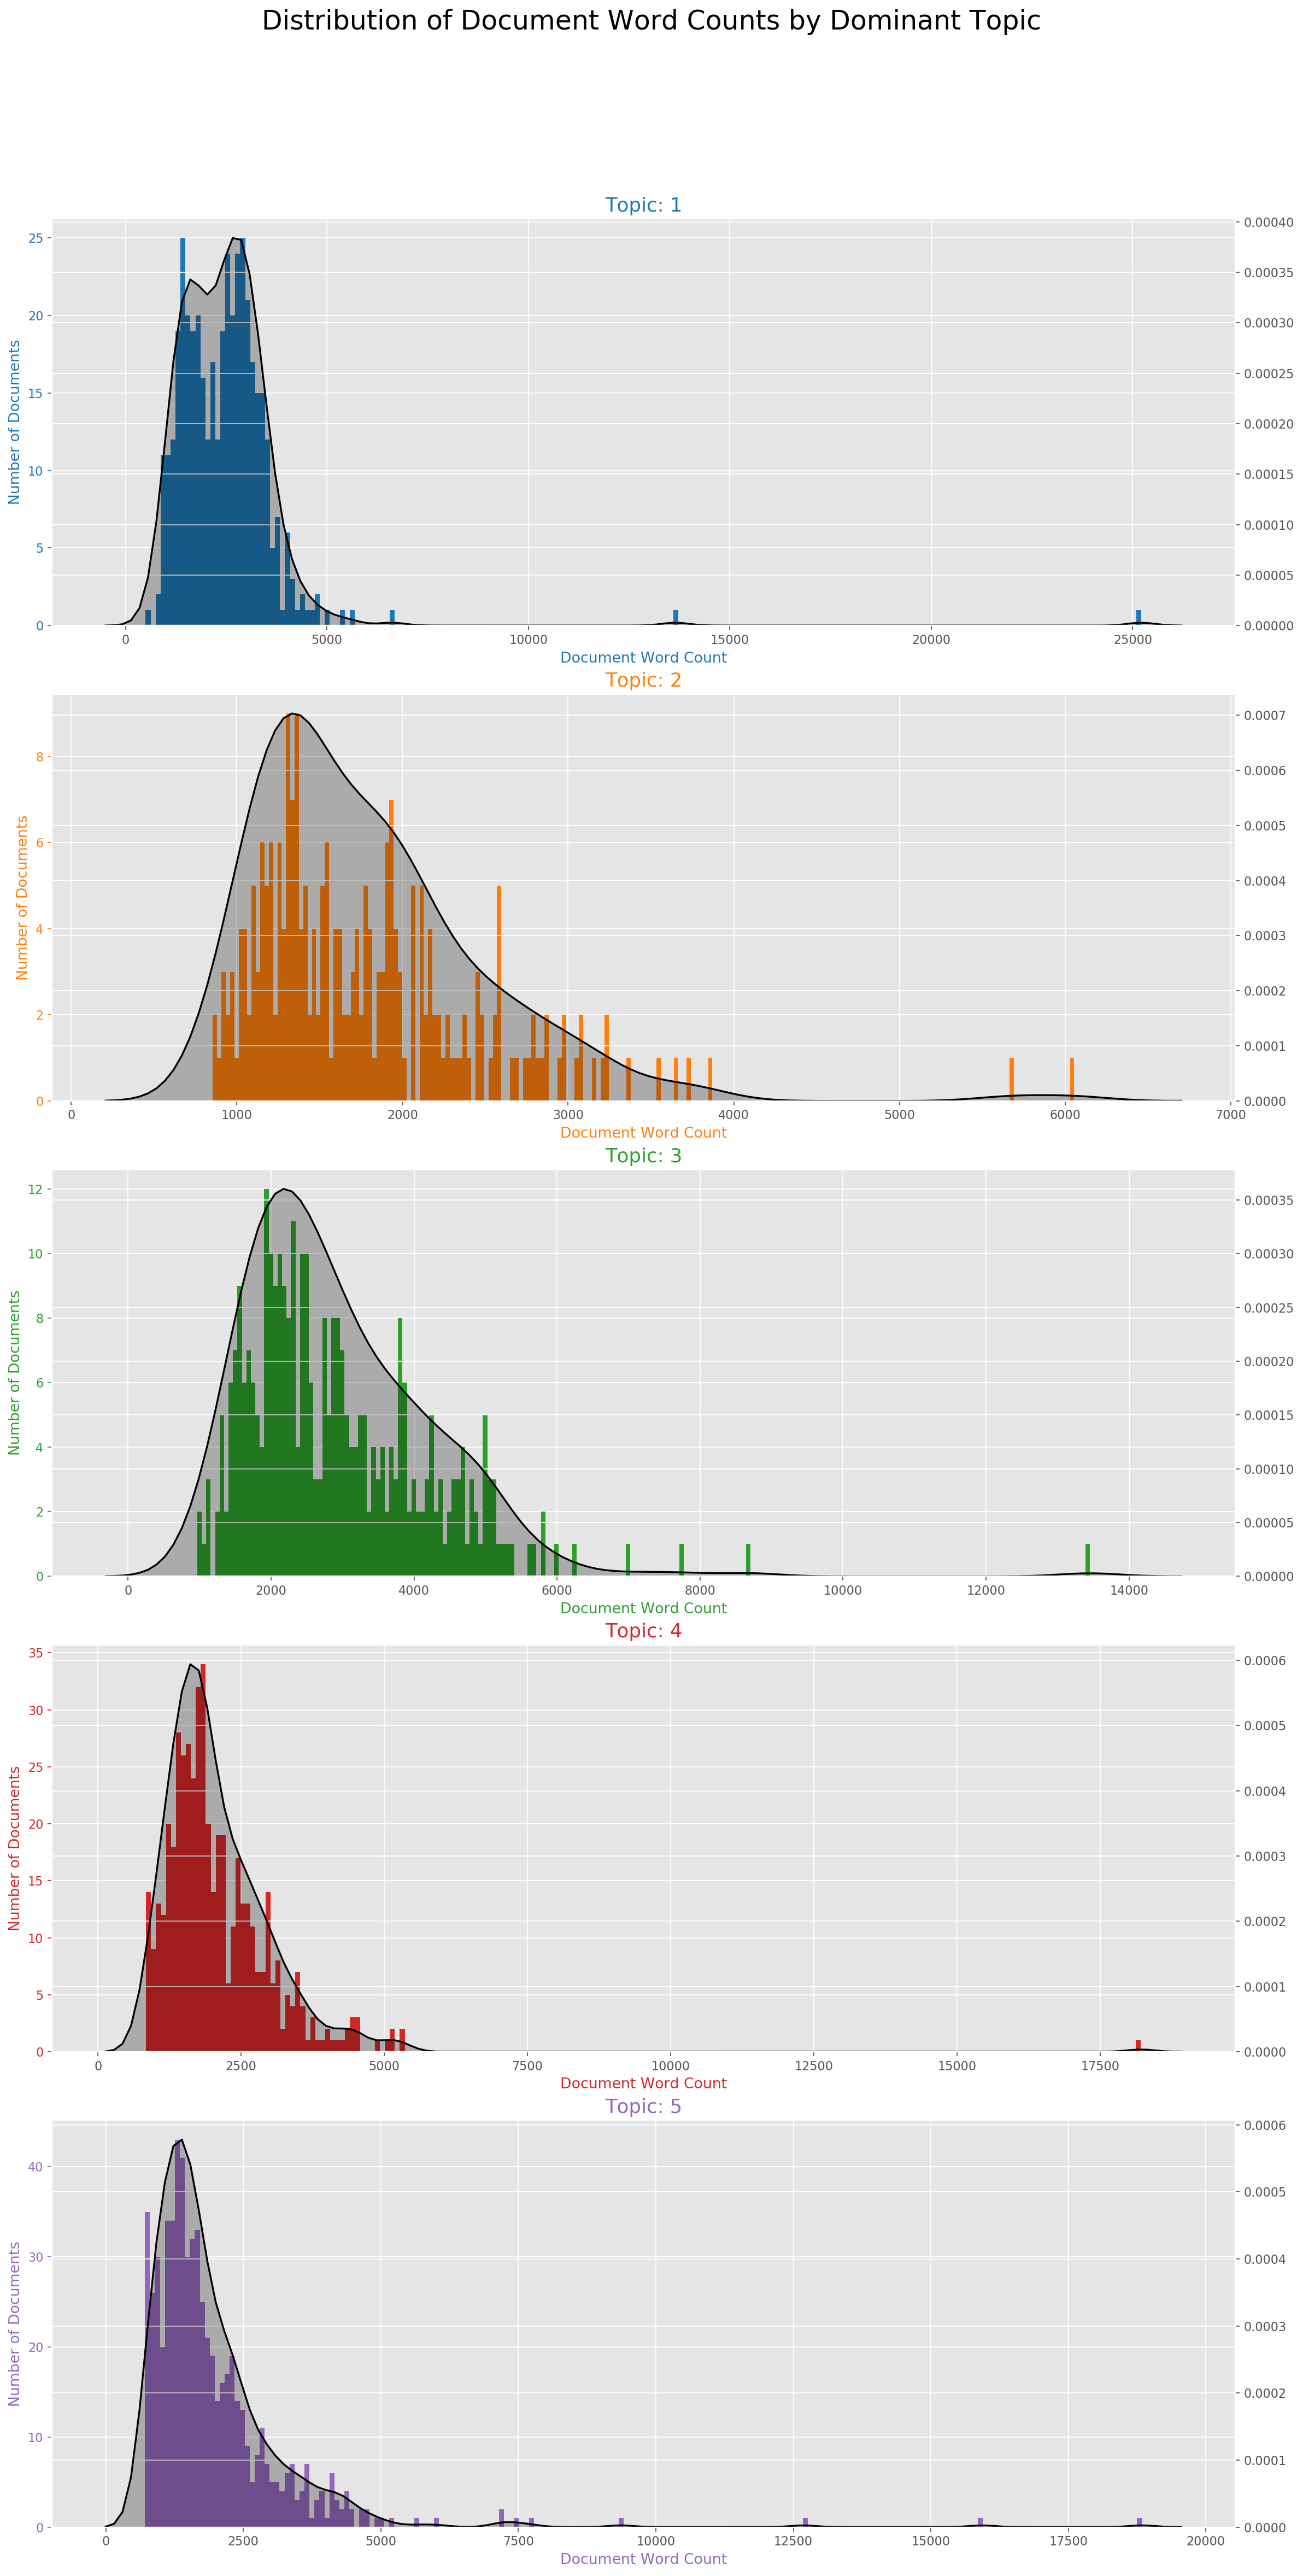

In [42]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,1,figsize=(15,30), dpi=160, sharex=False, sharey=False)
plt.style.use("ggplot")
for i, ax in enumerate(axes.flatten()):    
    
    # select first topic all records 
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic_No == i, :]
    
    # cal len of the text 
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    
    
    ax.hist(doc_lens, bins = 200, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=True, ax=ax.twinx())
    ax.set_xlabel('Document Word Count', color=cols[i])
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+1), fontdict=dict(size=16, color=cols[i]))


fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

 word cloud with the size of the words proportional to the weight is a pleasant sight.

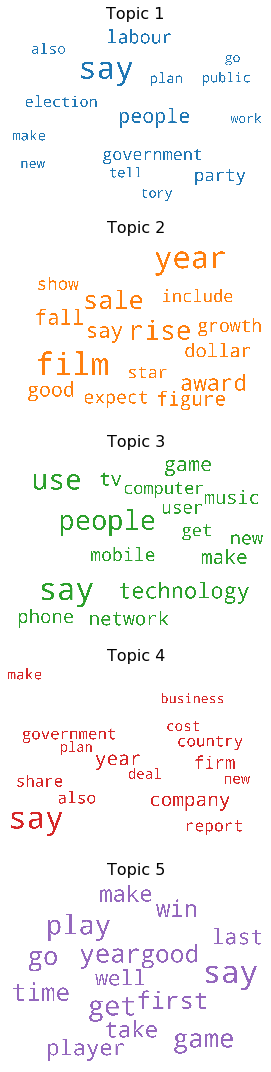

In [43]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

Total_words = 15

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=Total_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False,num_words=Total_words)

fig, axes = plt.subplots(5, 1, figsize=(30,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0.9, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.
Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

In [44]:
from collections import Counter
Total_words = 15
topics = optimal_model.show_topics(formatted=False,num_words=Total_words)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.head(10)

,word,topic_id,importance,word_count
0,say,0,0.036722,8424
1,people,0,0.010966,1890
2,labour,0,0.009152,663
3,party,0,0.008180,599
4,government,0,0.007667,1147
5,election,0,0.006176,470
6,also,0,0.005628,2035
7,make,0,0.005411,2090
8,tell,0,0.005263,607
9,plan,0,0.005212,769


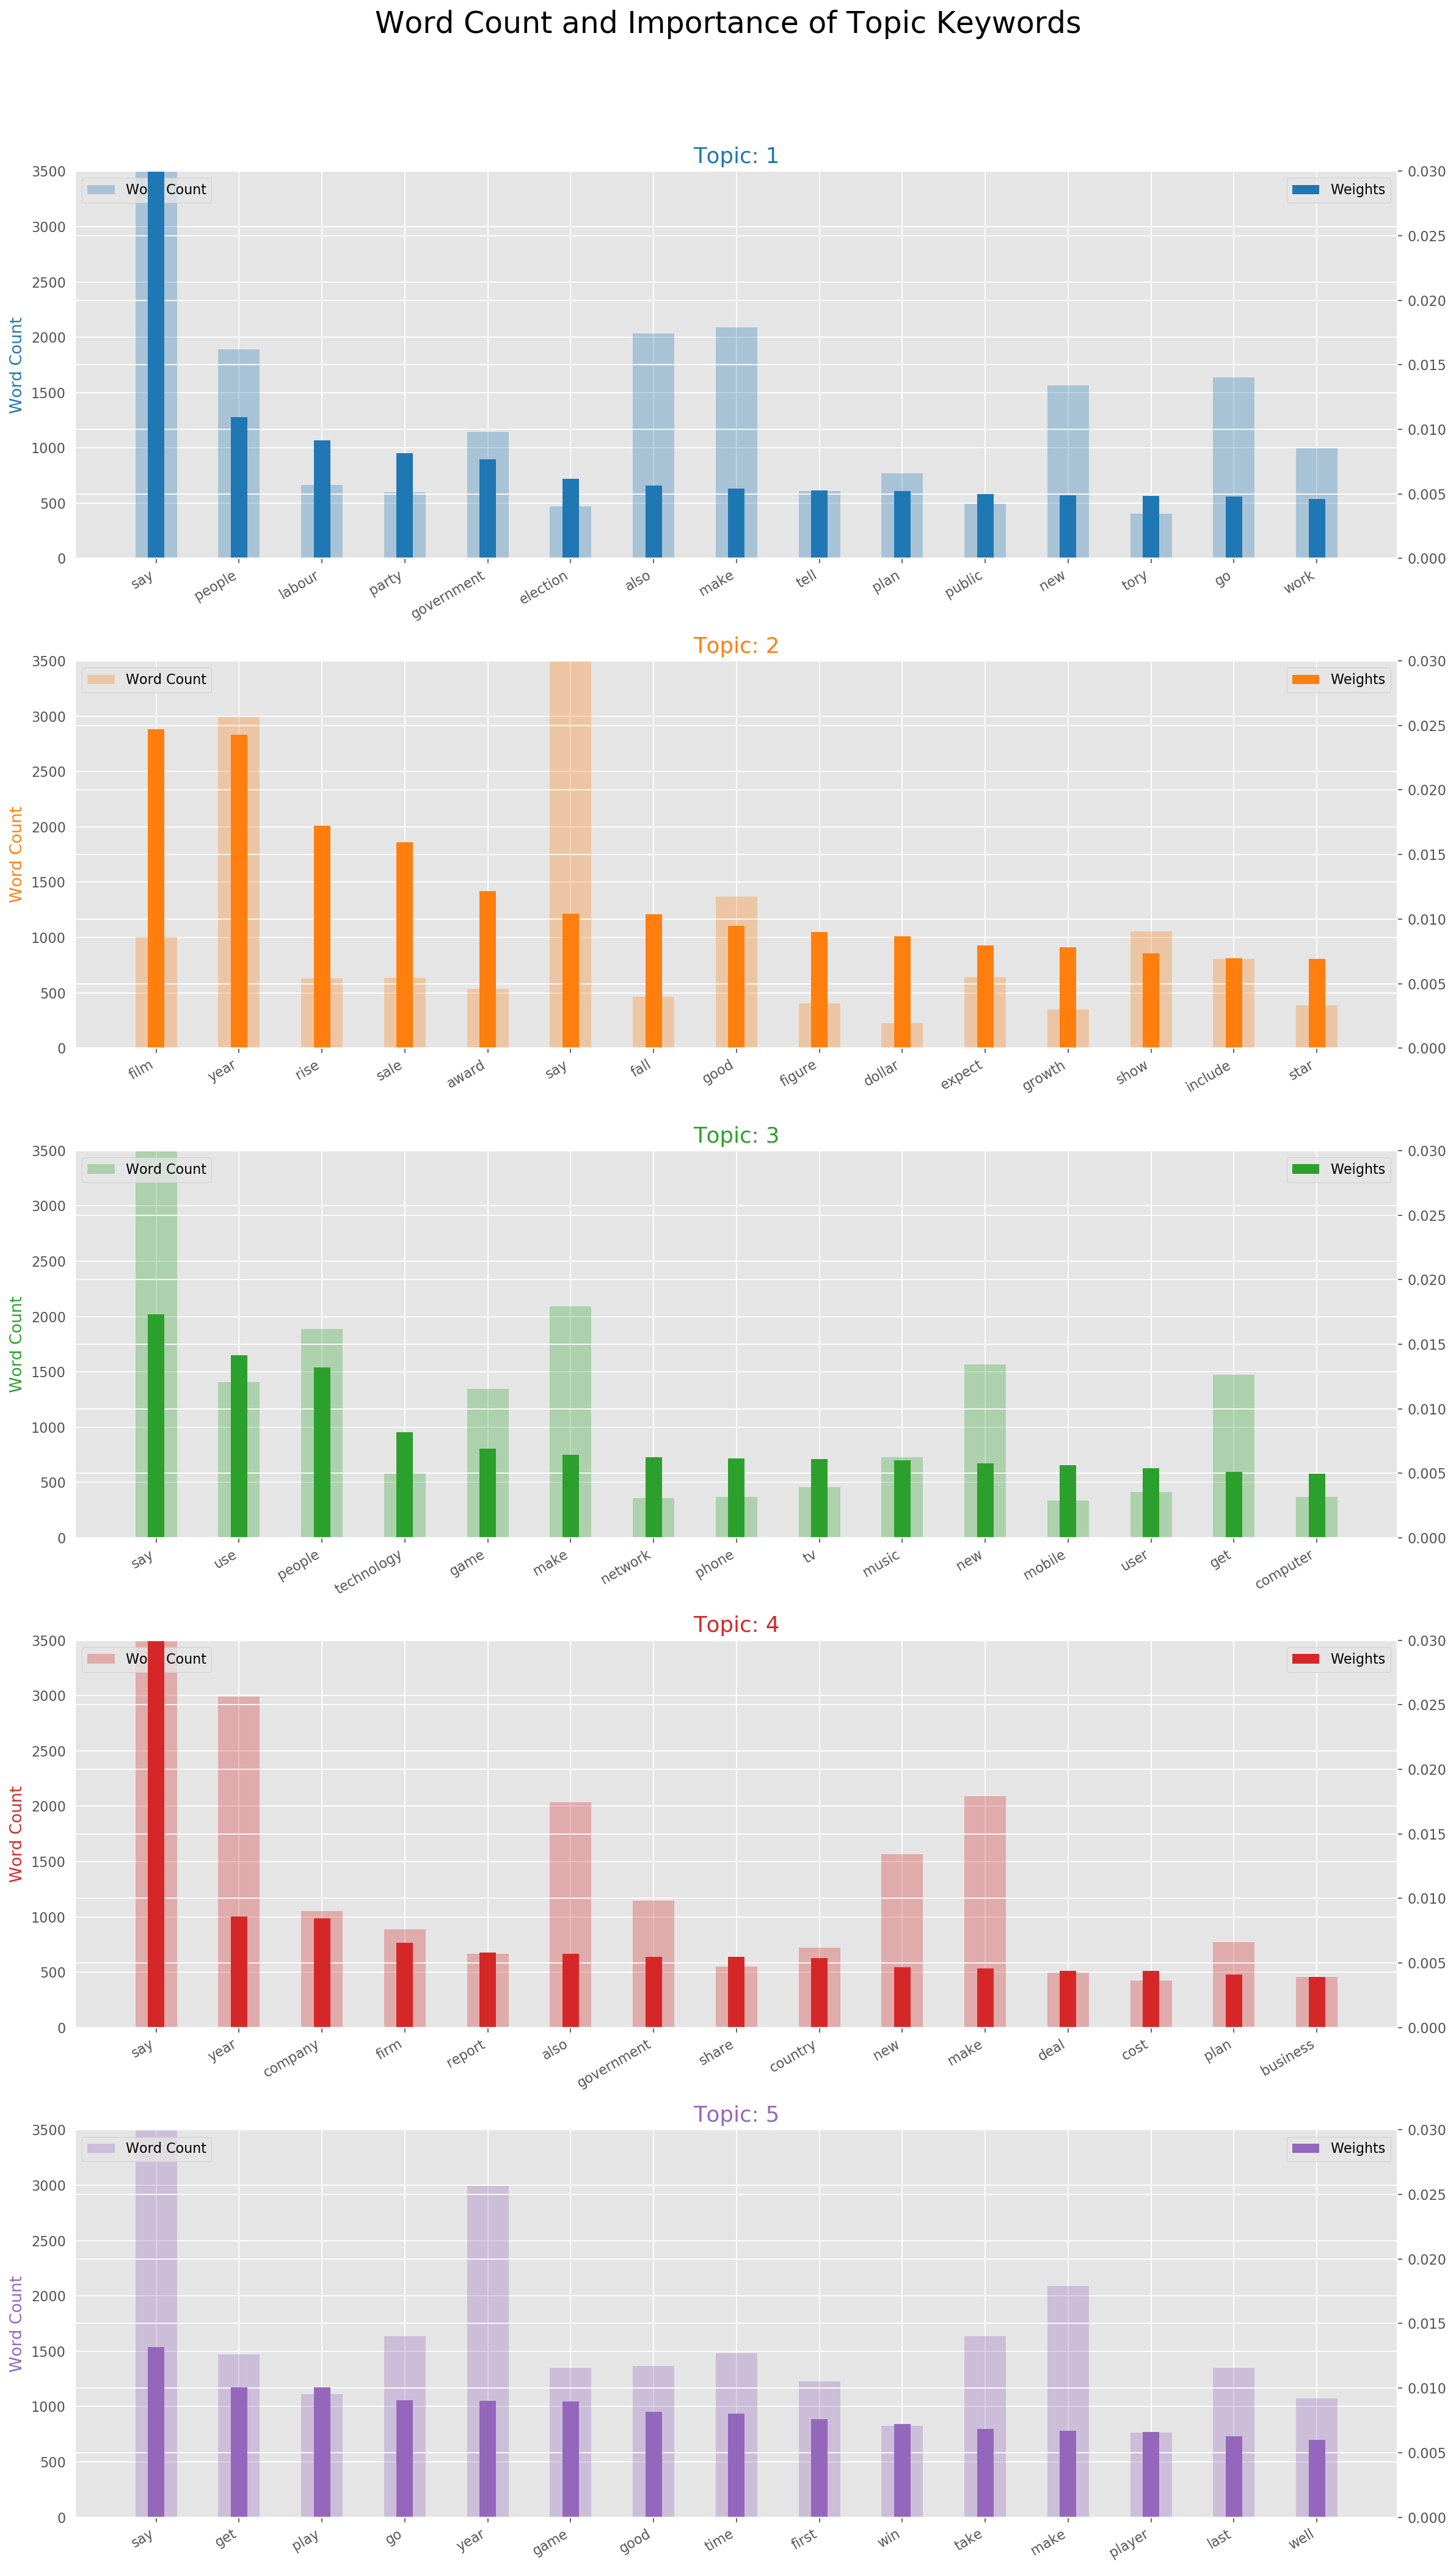

In [45]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(15,25), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic


Each word in the document is representative of one of the 5 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

In [47]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

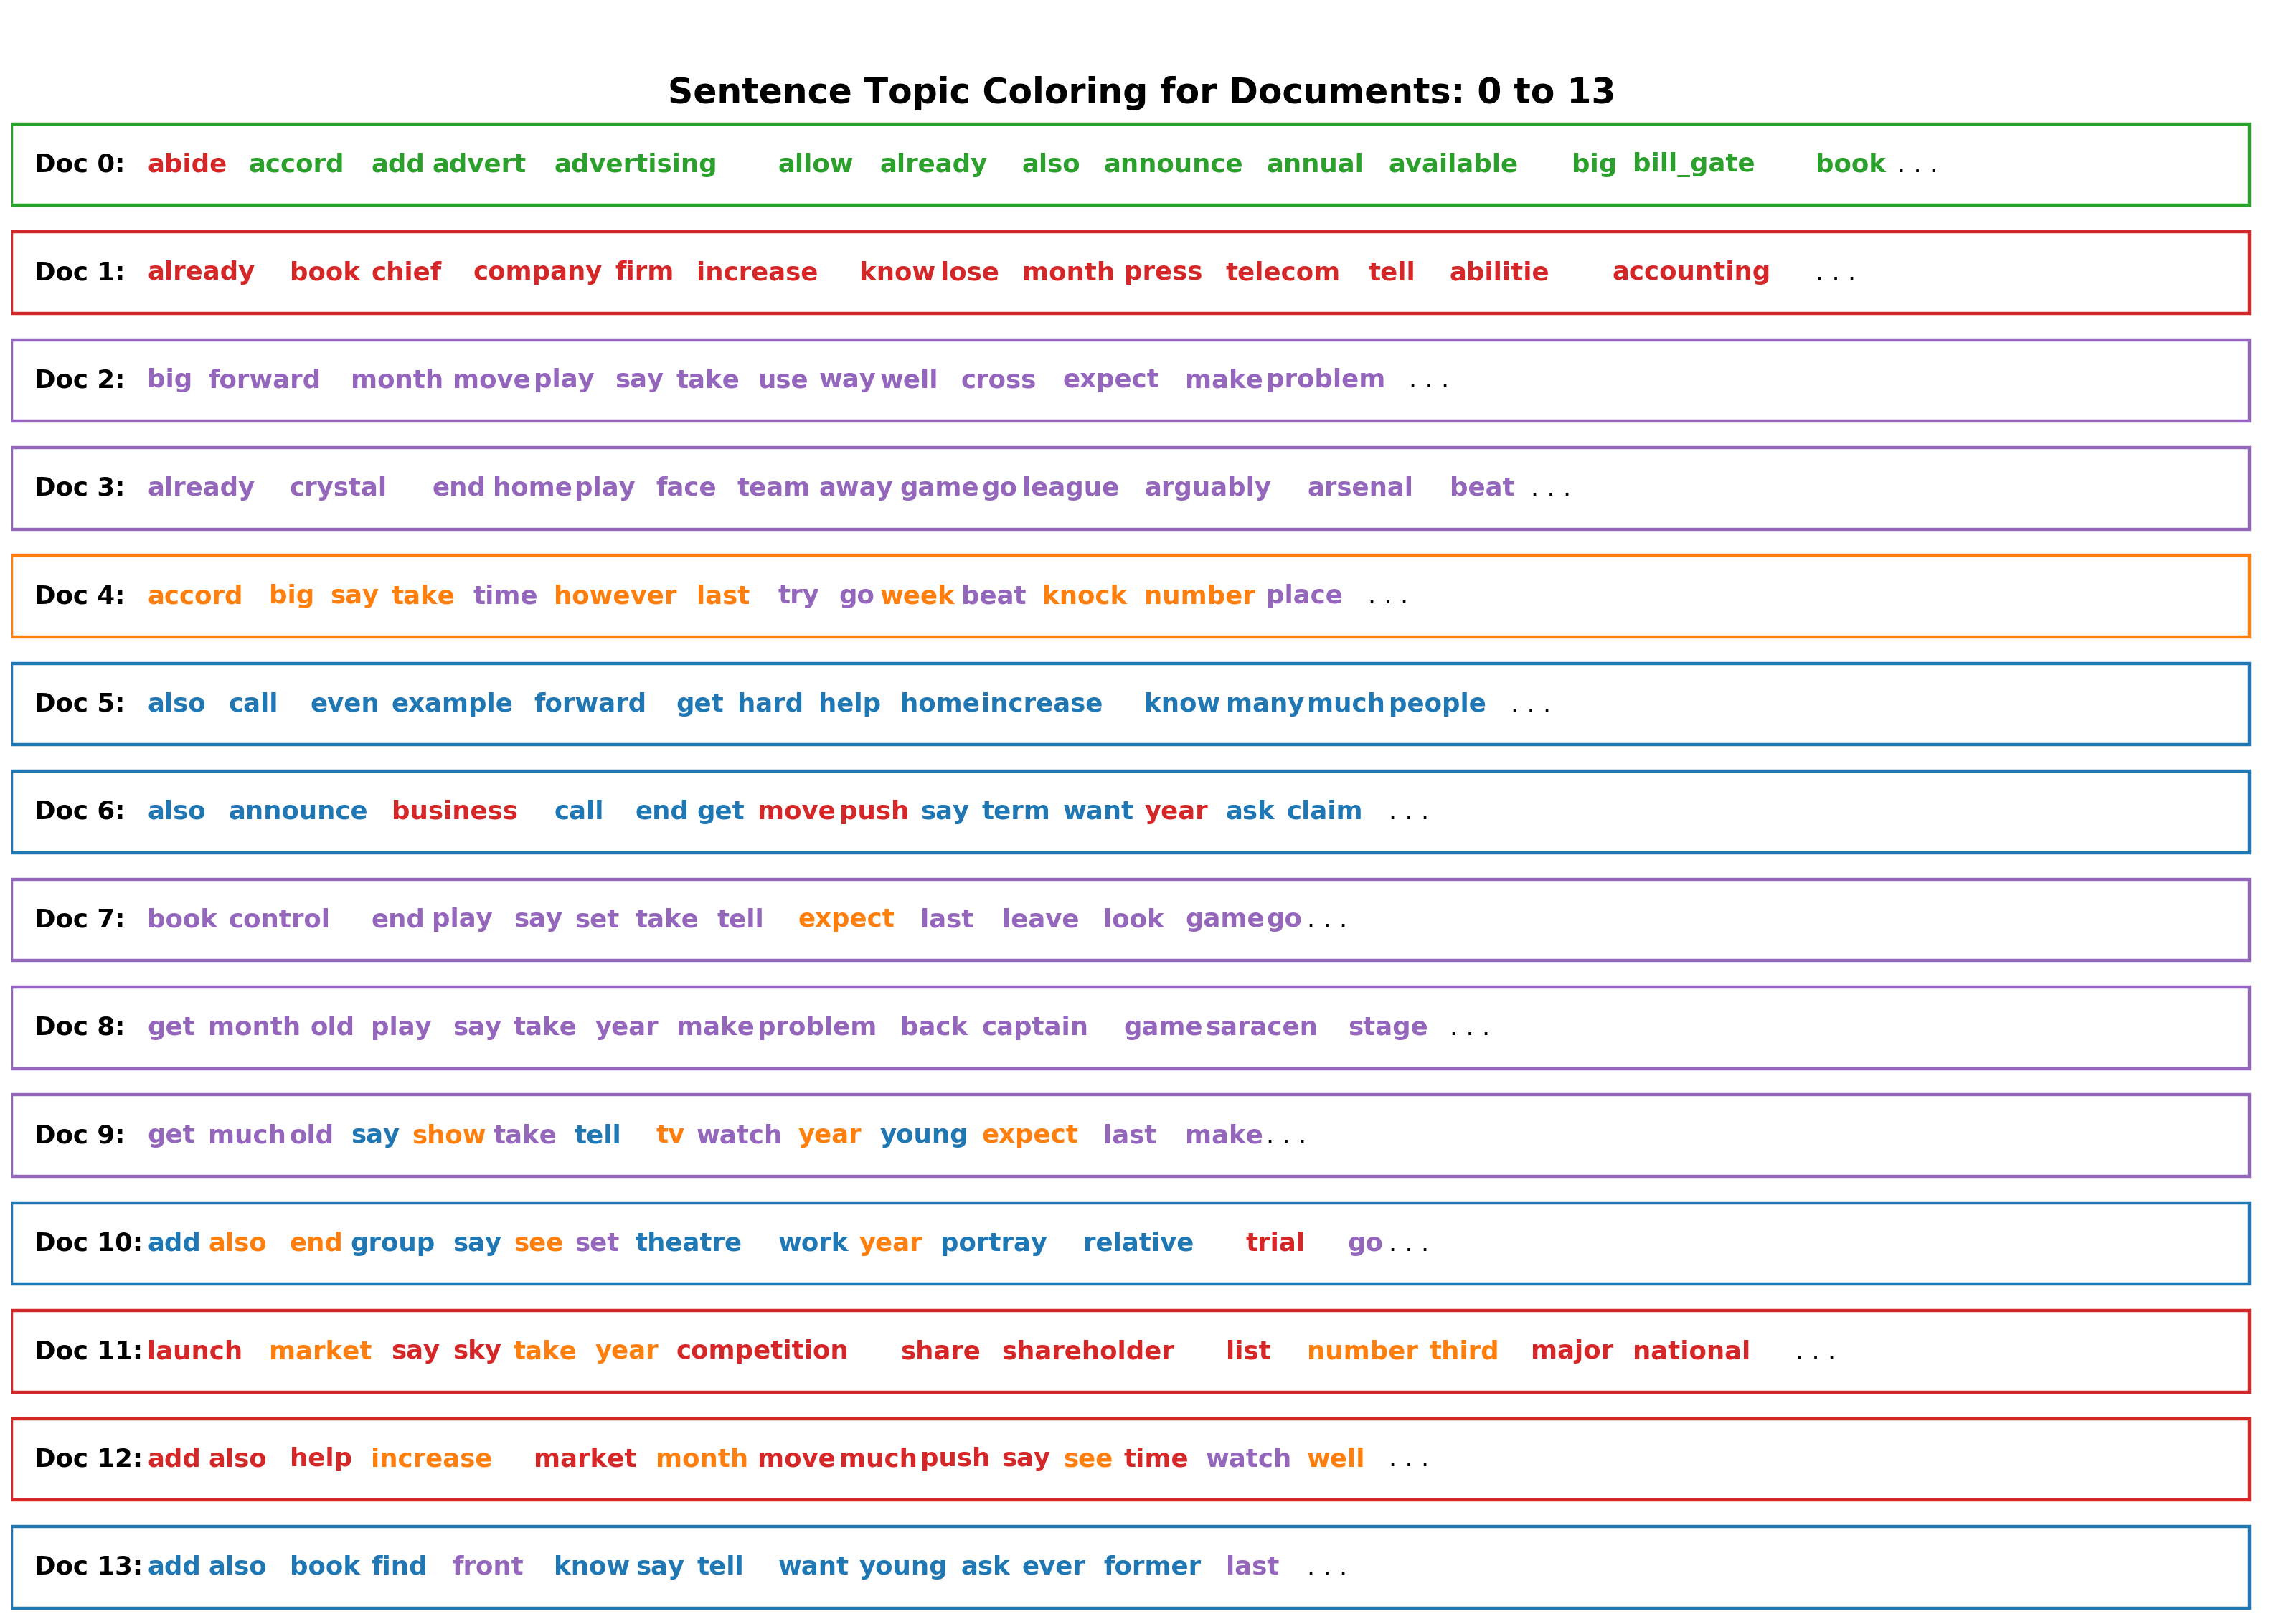

In [48]:
sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15)    

 ### What are the most discussed topics in the documents?

compute the total number of documents attributed to each topic.

In [49]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

1. The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
2. The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

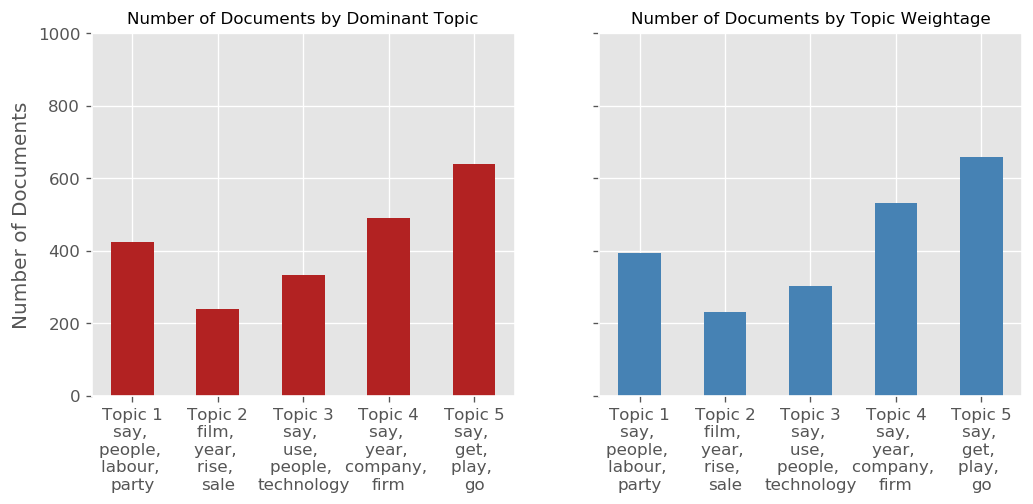

In [50]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [51]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\Devdatta Supnekar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Devdatta Supnekar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2081 samples in 0.009s...
[t-SNE] Computed neighbors for 2081 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2081
[t-SNE] Computed conditional probabilities for sample 2000 / 2081
[t-SNE] Computed conditional probabilities for sample 2081 / 2081
[t-SNE] Mean sigma: 0.007815
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.410759
[t-SNE] KL divergence after 1000 iterations: 0.561436


Loading BokehJS ...

### pyLDAVis

Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel()

In [54]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)
vis

C:\Users\Devdatta Supnekar\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.048469 -0.214991       1        1  27.157145
3     -0.021626  0.136775       2        1  24.195512
0     -0.160980  0.046594       3        1  20.364984
2     -0.049950  0.026735       4        1  19.069674
1      0.281025  0.004887       5        1   9.212686, topic_info=                   Term         Freq        Total Category  logprob  loglift
450                film   945.000000   945.000000  Default  30.0000  30.0000
208                year  2727.000000  2727.000000  Default  29.0000  29.0000
837                rise   712.000000   712.000000  Default  28.0000  28.0000
726                sale   785.000000   785.000000  Default  27.0000  27.0000
129              people  1864.000000  1864.000000  Default  26.0000  26.0000
134                play  1040.000000  1040.000000  Default  25.0000  25.0000
565              labour   662.000000   662.000000  Default  24.0000  24.0000
316                game  1330.000000  1330.000000  Default  23.0000  23.0000
196                 use  1400.000000  1400.000000  Default  22.0000  22.0000
455                good  1270.000000  1270.000000  Default  21.0000  21.0000
787               award   447.000000   447.000000  Default  20.0000  20.0000
580               party   592.000000   592.000000  Default  19.0000  19.0000
181          technology   553.000000   553.000000  Default  18.0000  18.0000
556          government  1026.000000  1026.000000  Default  17.0000  17.0000
866                fall   474.000000   474.000000  Default  16.0000  16.0000
160                 say  8122.000000  8122.000000  Default  15.0000  15.0000
426                 win   749.000000   749.000000  Default  14.0000  14.0000
33              company   960.000000   960.000000  Default  13.0000  13.0000
544            election   447.000000   447.000000  Default  12.0000  12.0000
905              dollar   341.000000   341.000000  Default  11.0000  11.0000
1413             figure   449.000000   449.000000  Default  10.0000  10.0000
120             network   424.000000   424.000000  Default   9.0000   9.0000
275               phone   417.000000   417.000000  Default   8.0000   8.0000
64                 firm   767.000000   767.000000  Default   7.0000   7.0000
485                star   388.000000   388.000000  Default   6.0000   6.0000
1030             player   761.000000   761.000000  Default   5.0000   5.0000
113              mobile   381.000000   381.000000  Default   4.0000   4.0000
825               music   699.000000   699.000000  Default   3.0000   3.0000
168                show  1012.000000  1012.000000  Default   2.0000   2.0000
2112             growth   315.000000   315.000000  Default   1.0000   1.0000
290                team   427.590326   428.382101   Topic1  -5.4184   1.3017
696               match   395.723685   396.508749   Topic1  -5.4959   1.3015
411                side   348.527293   349.314117   Topic1  -5.6229   1.3013
1013               goal   319.467780   320.282765   Topic1  -5.7099   1.3010
754              minute   280.075054   280.870794   Topic1  -5.8415   1.3007
2290              album   244.750186   245.534941   Topic1  -5.9764   1.3003
1589             winner   218.936319   219.732844   Topic1  -6.0878   1.2999
957              career   211.654697   212.442394   Topic1  -6.1216   1.2998
720              injury   199.862273   200.637188   Topic1  -6.1790   1.2997
1615               race   198.135404   198.930831   Topic1  -6.1877   1.2995
708             victory   177.999118   178.779386   Topic1  -6.2948   1.2992
1839               band   179.960166   180.756997   Topic1  -6.2839   1.2991
2173               ball   163.424860   164.203495   Topic1  -6.3802   1.2988
700               score   163.570813   164.350482   Topic1  -6.3794   1.2988
1002              coach   147.813329   148.589183   Topic1  -6.4807   1.2983
550              finish   141.374328 